In [1]:
import os, sys
cwd = os.getcwd()
sys.path.insert(0, f"{cwd}/../")

# Import RBIG Function
import numpy as np
from rbig.data import ToyData
from rbig.linear import OrthogonalTransform
from rbig.quantile import QuantileGaussian
from rbig.layers import RBIGBlock
from rbig.models import RBIGFlow, RBIG
from scipy import stats

# Plot Functions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [2]:
def plot_2d_joint(data, color='red', kind='hex'):
    
    fig  = plt.figure(figsize=(10, 10))

    g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind=kind, color=color)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Original Data')
    plt.tight_layout()
    plt.show()
    
def plot_prob(data, probs):
    
    fig, ax = plt.subplots()

    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = plt.colorbar(h, )
    plt.show()

<Figure size 720x720 with 0 Axes>

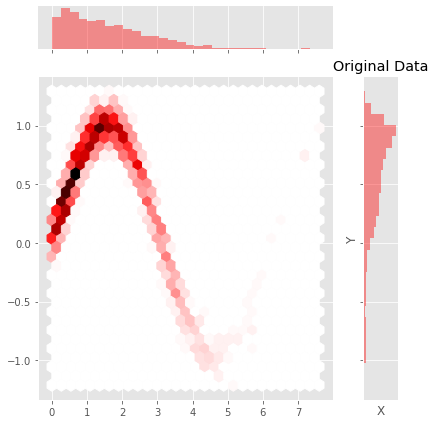

In [4]:
seed = 123
rng = np.random.RandomState(seed=seed)
dataset = 'rbig'
n_samples = 2_000
noise = 0.1
random_state=123


data = ToyData(
    dataset, n_samples, noise, random_state).generate_samples()
X = data[:, 0]
Y = data[:, 1]

plot_2d_joint(data, 'red')

## RBIG Components

### 1. Rotation (Orthogonal ICA)

In [138]:
rotation = 'ica'
random_state = 123

transform_R = OrthogonalTransform(rotation=rotation, random_state=random_state,)

data_R = transform_R.fit_transform(data)

<Figure size 720x720 with 0 Axes>

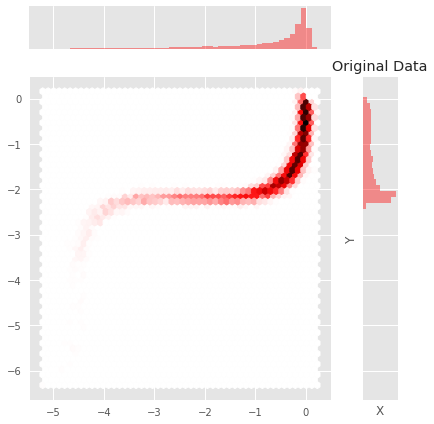

In [139]:
plot_2d_joint(data_R)

### 2. Marginal Gaussianization (Quantile Transformer)

In [140]:
n_quantiles = 1_000
subsample = 2_000
random_state = 123
bin_est = None

transform_G = QuantileGaussian(
    n_quantiles=n_quantiles,
    subsample = subsample,
    random_state=random_state,
)

data_G = transform_G.fit_transform(data_R);

<Figure size 720x720 with 0 Axes>

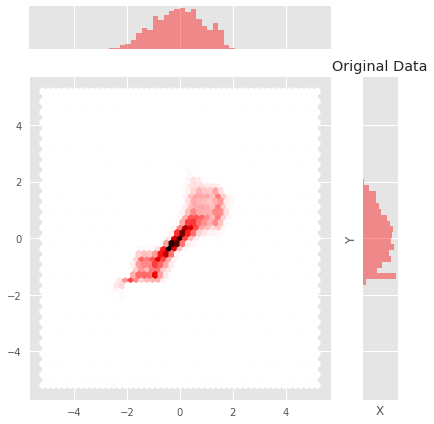

In [141]:
plot_2d_joint(data_G)

### Metrics

#### 1. Log Probability (X)

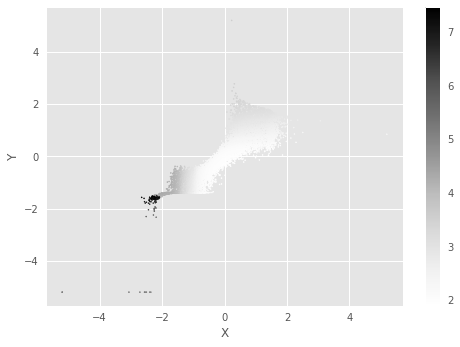

In [142]:
data_r_lprob = transform_R.score_samples(data)
data_g_lprob = transform_G.score_samples(data)

plot_prob(data_G, data_g_lprob)

#### 2. Mean Log-Likelihood (X)

In [143]:
data_r_mlprob = transform_R.score(data)
data_g_mlprob = transform_G.score(data)

data_score = data_r_mlprob + data_g_mlprob

print(f"Mean Log-Likelhood: {data_score}")

Mean Log-Likelhood: 2.5246450681162345


## RBIG Block

To keep in touch with modern frameworks, we can think of this as a block of operations denoted RBIG-block.

1. Orthogonal Rotation
2. Marginal Gaussianization

We have a few functions that we need to operate:

1. fit
2. transform
3. inverse_transform
4. score_samples (i.e. log prob)
4. score (i.e. mean log likelihood)
6. Sample
5. Entropy
6. Multi-Information / Total Correlation (TODO)


#### Forward Transformation

<Figure size 720x720 with 0 Axes>

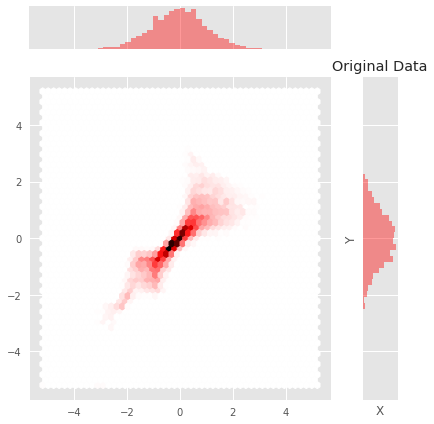

In [144]:
rbig_block = RBIGBlock(rotation='ica', n_quantiles=1_000, subsample=2_000)

rbig_block.fit(data);

data_G = rbig_block.transform(data)

plot_2d_joint(data_G)



#### Reverse Transformation

<Figure size 720x720 with 0 Axes>

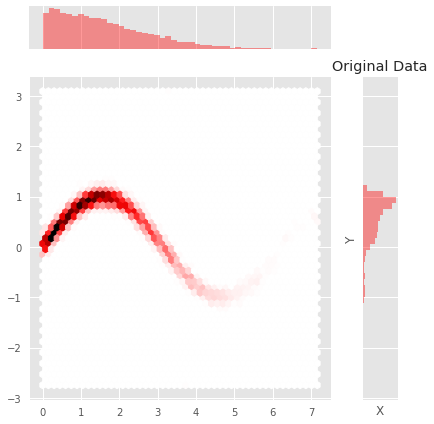

In [145]:
data_ori = rbig_block.inverse_transform(data_G)

# np.testing.assert_array_almost_equal(data, data_ori, decimal=5)

plot_2d_joint(data_ori)



#### Sampling

We can sample from a Normal distribution and push it through the inverse transformation.

$$X \sim \mathcal{N}(0, 1)$$



<Figure size 720x720 with 0 Axes>

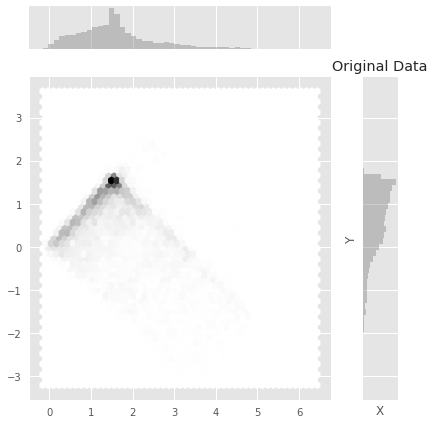

In [147]:
n_samples = 10_000
data_sample = rbig_block.sample(n_samples)

plot_2d_joint(data_sample, 'gray')


#### Scoring Samples

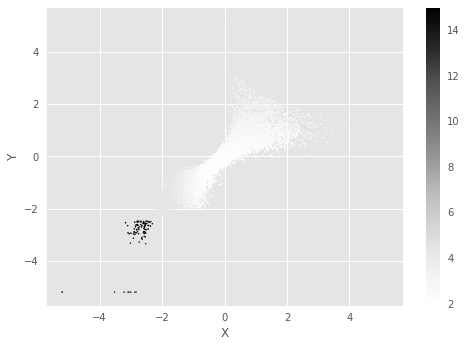

In [148]:
data_lprob = rbig_block.score_samples(data)


plot_prob(data_G, data_lprob)

#### Mean Log-Likelihood

In [149]:
data_score = rbig_block.score(data)


print(f"Mean Log-Likelhood: {data_score}")

Mean Log-Likelhood: 2.587355005669763


## Stacking RBIG Blocks

<Figure size 720x720 with 0 Axes>

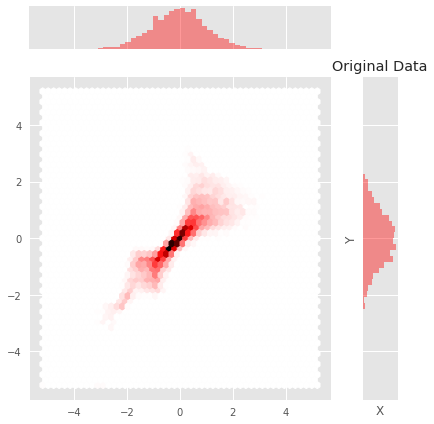

<Figure size 720x720 with 0 Axes>

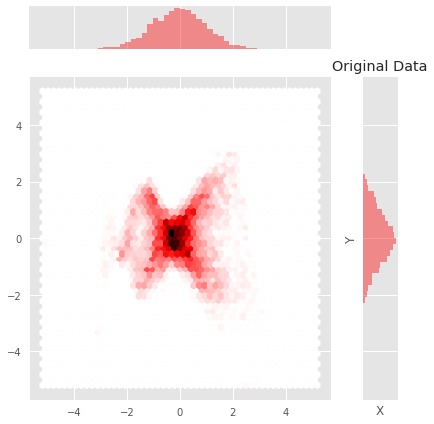

<Figure size 720x720 with 0 Axes>

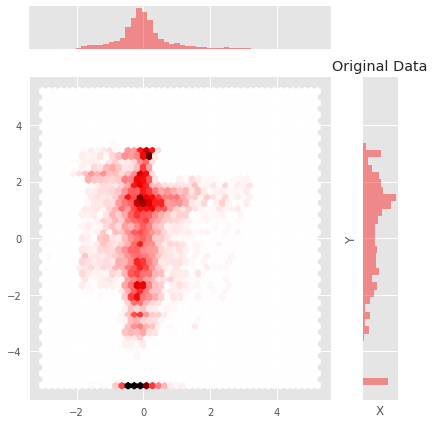

In [150]:
# Transformation 1
rbig_block_1 = RBIGBlock(rotation='ica')

rbig_block_1.fit(data);

data_G1 = rbig_block_1.transform(data)

plot_2d_joint(data_G1)

# Transformation II
rbig_block_2 = RBIGBlock(rotation='ica')

rbig_block_2.fit(data_G1);

data_G2 = rbig_block_2.transform(data_G1)

plot_2d_joint(data_G2)


# Transformation III
rbig_block_3 = RBIGBlock(rotation='ica')

rbig_block_3.fit(data_G2);

data_G3 = rbig_block_2.transform(data_G2)

plot_2d_joint(data_G3)


## RBIG Flow

For the final part, we will show how we can stack 'RBIG Blocks' on top of each other to form the RBIG algorithm. Then we can see how the transformation dramatically changes.

#### Forward Transformation

<Figure size 720x720 with 0 Axes>

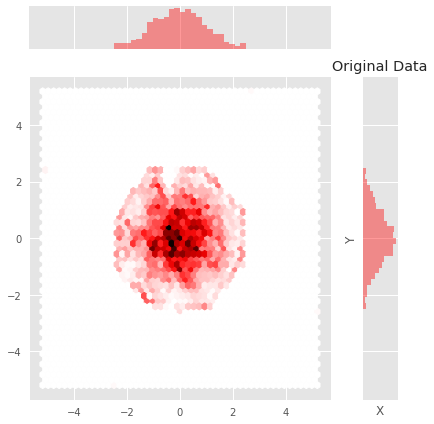

In [164]:
rbig_flow = RBIGFlow(10, 'ica', n_quantiles=1_000, support_ext=1.0, interp='slinear')

rbig_flow.fit(data)

data_G  = rbig_flow.transform(data)

plot_2d_joint(data_G)


#### Inverse Transformation

<Figure size 720x720 with 0 Axes>

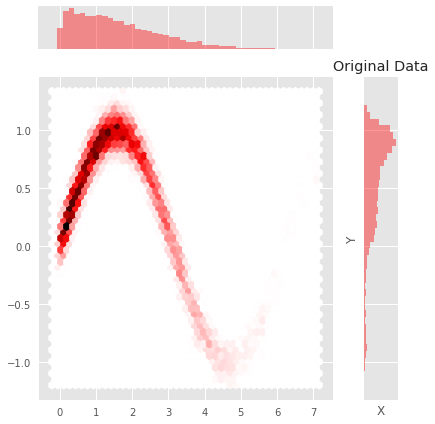

In [165]:
data_ori  = rbig_flow.inverse_transform(data_G)

# np.testing.assert_array_almost_equal(data, data_ori, decimal=4)

plot_2d_joint(data_ori)

#### Sampling

<Figure size 720x720 with 0 Axes>

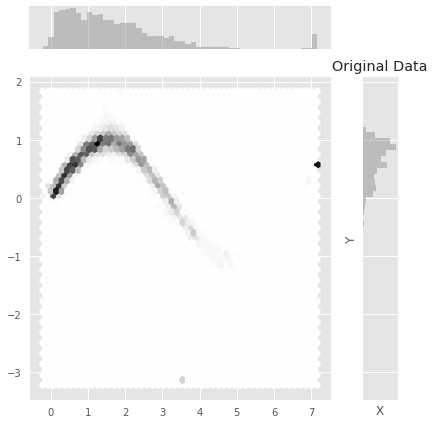

In [166]:
n_samples = 10_000
data_sample = rbig_flow.sample(n_samples)

plot_2d_joint(data_sample, 'gray')


#### Log Probability

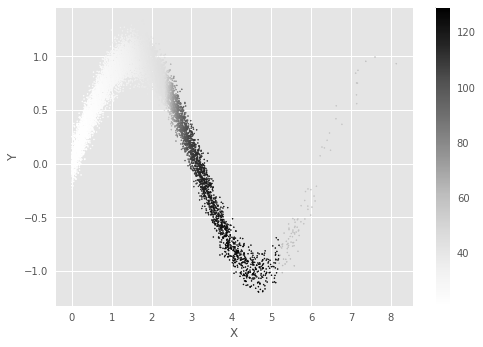

In [167]:
data_lprob = rbig_flow.score_samples(data)

plot_prob(data, data_lprob)

#### Mean Log-Likelihood

In [168]:
score = rbig_flow.score(data)

print(f"Mean Log-Likelihood Score: {score:.4f}")

Mean Log-Likelihood Score: 46.5853


## Iterative Gaussianization Algorithm

#### RBIG Params

In [5]:
# RBIG Params
max_layers=10,
rotation="pca",
n_quantiles=1_000,
subsample=1_000,
random_state=123,
support_ext=0.0,
interp="linear",
entropy_alg="histogram",
# Info Reduction Params
p_value=0.25,
univariate_method="histogram",
bins="auto",
correction=True,
k=10,
kernel="gau",
bw="normal_reference",
# Loss Function Params
loss_tolerance=50,

#### Model

In [45]:
rbig_clf = RBIG(
    # RBIG Params
    max_layers=1_000,
    rotation="pca",
    n_quantiles=1_000,
    subsample=1_000,
    random_state=123,
    support_ext=0.,
    interp="linear",
    # Info Reduction Params
    p_value=0.01,
    univariate_method="histogram",
    bins="auto",
    correction=True,
    k=10,
    kernel="gau",
    bw="normal_reference",
    # Loss Function Params
    loss_tolerance=200,
)

rbig_clf.fit(data);

<Figure size 720x720 with 0 Axes>

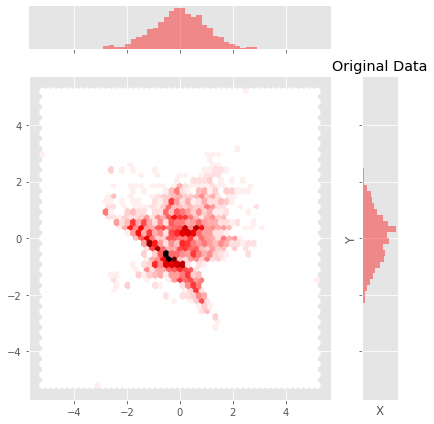

In [46]:
data_G  = rbig_clf.transform(data)

plot_2d_joint(data_G, kind='hex')


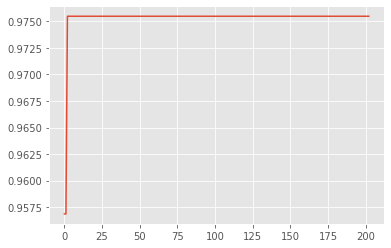

In [47]:
plt.plot(np.cumsum(rbig_clf.info_reduction))